## Data Loading and Initial Inspection
Load the dataset, check for file existence, and display basic information such as the first few rows, dataset info, and descriptive statistics.

In [17]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

file_path = os.path.join('..','data', 'Olympic_Swimming.csv')

# Check if the file exists
if not os.path.exists(file_path):
    print(f"Error: Data file not found at {file_path}")
else:
    df = pd.read_csv(file_path)
    print("Data loaded successfully!")

# Display basic information
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nDescriptive Statistics:")
print(df.describe())

Data loaded successfully!

First 5 rows:
  Location  Year Distance (in meters)      Stroke  Relay? Gender Team  \
0    Tokyo  2020                 100m  Backstroke       0    Men  ROC   
1    Tokyo  2020                 100m  Backstroke       0    Men  ROC   
2    Tokyo  2020                 100m  Backstroke       0    Men  USA   
3    Tokyo  2020                 100m  Backstroke       0    Men  ITA   
4    Tokyo  2020                 100m  Backstroke       0    Men  CHN   

              Athlete Results  Rank  
0        Evgeny Rylov   51.98     1  
1  Kliment Kolesnikov      52     2  
2         Ryan Murphy   52.19     3  
3       Thomas Ceccon    52.3     4  
4            Jiayu Xu   52.51     4  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4359 entries, 0 to 4358
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Location              4359 non-null   object
 1   Year           

## Data Cleaning and Handling Missing Values.
Identify missing values, drop rows with missing 'Athlete' or 'Results', and verify the dataset after cleaning.

In [18]:
print(df.isnull().sum())

Location                 0
Year                     0
Distance (in meters)     0
Stroke                   0
Relay?                   0
Gender                   0
Team                     0
Athlete                 14
Results                 28
Rank                     0
dtype: int64


In [19]:
# Drop rows where 'Athlete' or 'Results' are missing
# We drop these because athlete name is a key identifier and missing results are hard to impute meaningfully for prediction
initial_rows = len(df)
df.dropna(subset=['Athlete', 'Results'], inplace=True)
rows_after_dropping = len(df)

print(f"\nDropped rows with missing 'Athlete' or 'Results'.")
print(f"Initial rows: {initial_rows}")
print(f"Rows after dropping: {rows_after_dropping}")
print(f"Number of rows dropped: {initial_rows - rows_after_dropping}")

# Verify missing values again
print("\nMissing values per column after dropping:")
print(df.isnull().sum())


Dropped rows with missing 'Athlete' or 'Results'.
Initial rows: 4359
Rows after dropping: 4317
Number of rows dropped: 42

Missing values per column after dropping:
Location                0
Year                    0
Distance (in meters)    0
Stroke                  0
Relay?                  0
Gender                  0
Team                    0
Athlete                 0
Results                 0
Rank                    0
dtype: int64


## Convert Results to Seconds
Define a function to convert time formats (e.g., '1:44.22') into seconds and apply it to the 'Results' column.

In [20]:
import re

def time_to_seconds(t):
    """'51.98' → 51.98 ; '1:44.22' → 104.22 ; '00:01:04.93' → 64.93"""
    if pd.isna(t): return None
    t = str(t).strip()
    if re.fullmatch(r"\d+(\.\d+)?", t):           # under a minute
        return float(t)
    if re.fullmatch(r"\d+:\d+(\.\d+)?", t):       # mm:ss.ss
        m, s = t.split(":")
        return int(m)*60 + float(s)
    if re.fullmatch(r"\d+:\d+:\d+(\.\d+)?", t):   # hh:mm:ss.ss
        h, m, s = t.split(":")
        return int(h)*3600 + int(m)*60 + float(s)
    return None

df["result_seconds"] = df["Results"].apply(time_to_seconds)

In [21]:
df["result_seconds"].describe()

count    4212.000000
mean      209.100729
std       215.149890
min        21.070000
25%        66.815000
50%       132.870000
75%       251.737500
max      1395.400000
Name: result_seconds, dtype: float64

## Extract Distance and Relay Flag
Extract numeric distance values from the 'Distance (in meters)' column and convert the 'Relay?' column to a boolean flag.

In [22]:
df["is_relay"]  = df["Relay?"].astype(bool)
df["distance_m"] = df["Distance (in meters)"].str.extract(r"(\d+)").astype(int)

## Clean Categorical Columns
Strip whitespace and convert columns like 'Stroke', 'Gender', 'Team', and 'Location' to categorical data types.

In [23]:
cat_cols = ["Stroke", "Gender", "Team", "Location"]
for c in cat_cols:
    df[c] = df[c].str.strip().astype("category")

## Results Per Olympic Year
Visualize the number of results per Olympic year using a horizontal bar chart.

Text(0.5, 0, 'results count')

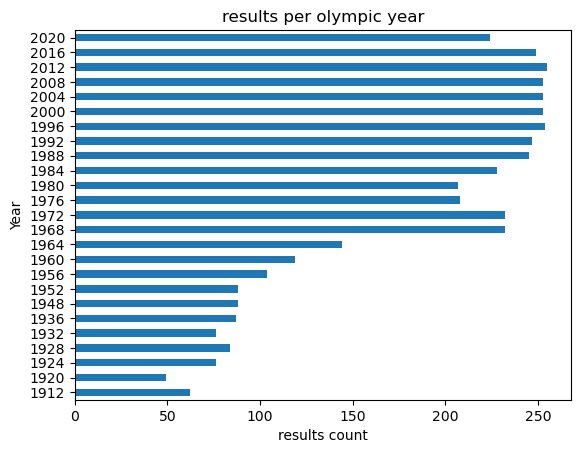

In [24]:
df["Year"].value_counts().sort_index().plot(kind="barh", title="results per olympic year")
plt.title("results per olympic year")
plt.xlabel("results count")

## Evolution of 100m Gold-Medal Times
Plot the trend of 100m gold-medal times over the years for different strokes, inverting the y-axis for better visualization.

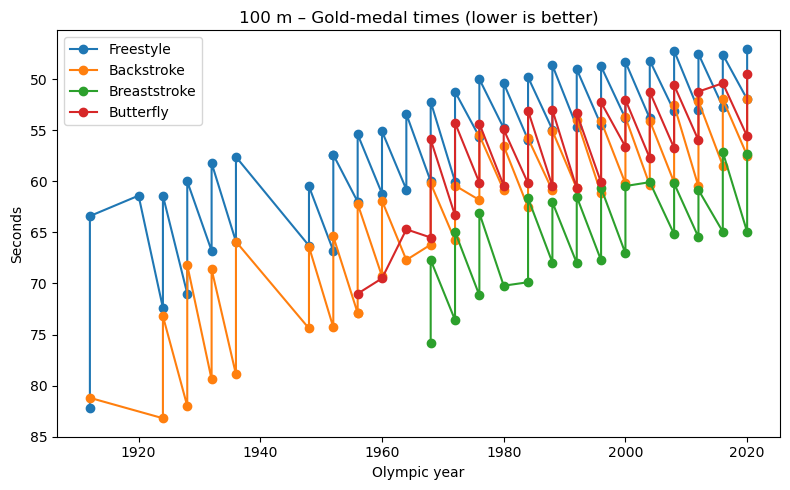

In [25]:
# Keep only gold medals (Rank == 1)
gold = df[df["Rank"] == 1]
plt.figure(figsize=(8, 5))
for stroke in ["Freestyle", "Backstroke", "Breaststroke", "Butterfly"]:
    sub = gold[(gold["distance_m"] == 100) & (gold["Stroke"] == stroke)]
    plt.plot(sub["Year"], sub["result_seconds"], marker="o", label=stroke)

plt.gca().invert_yaxis()      # Lower = faster, so invert for intuitive visual
plt.title("100 m – Gold-medal times (lower is better)")
plt.xlabel("Olympic year")
plt.ylabel("Seconds")
plt.legend()
plt.tight_layout()
plt.show()

## Box-Plot: Gender Gap on 100m
Create a box plot to compare the distribution of 100m times by stroke and gender.

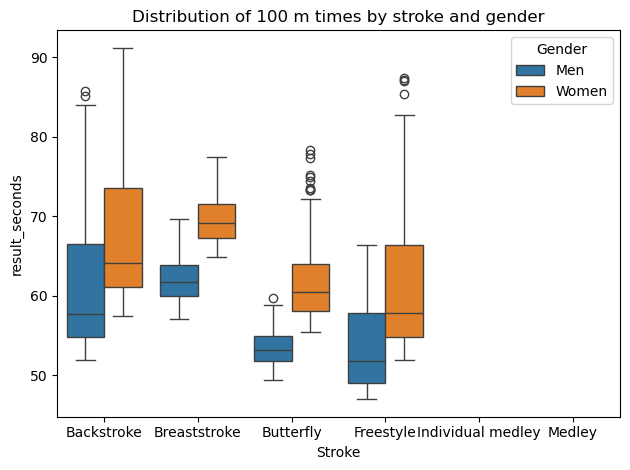

In [26]:
sns.boxplot(
    data=df[df["distance_m"] == 100],
    x="Stroke", y="result_seconds", hue="Gender"
)
plt.title("Distribution of 100 m times by stroke and gender")
plt.tight_layout()
plt.show()

## Top 10 Gold-Medal Countries
Identify and visualize the top 10 countries with the most gold medals using a bar chart.

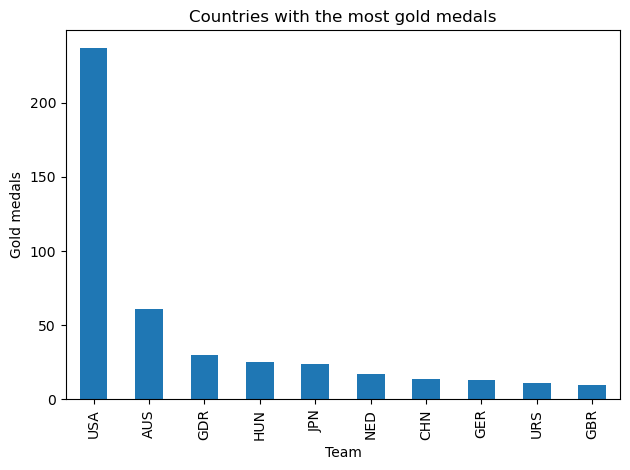

In [27]:
top = (
    df[df["Rank"] == 1]["Team"]
    .value_counts()
    .head(10)
)

top.plot(kind="bar", title="Countries with the most gold medals")
plt.ylabel("Gold medals")
plt.tight_layout()
plt.show()

## Total Medals Awarded Per Year
Plot the total number of medalists (Ranks 1, 2, 3) per Olympic year using a line chart.

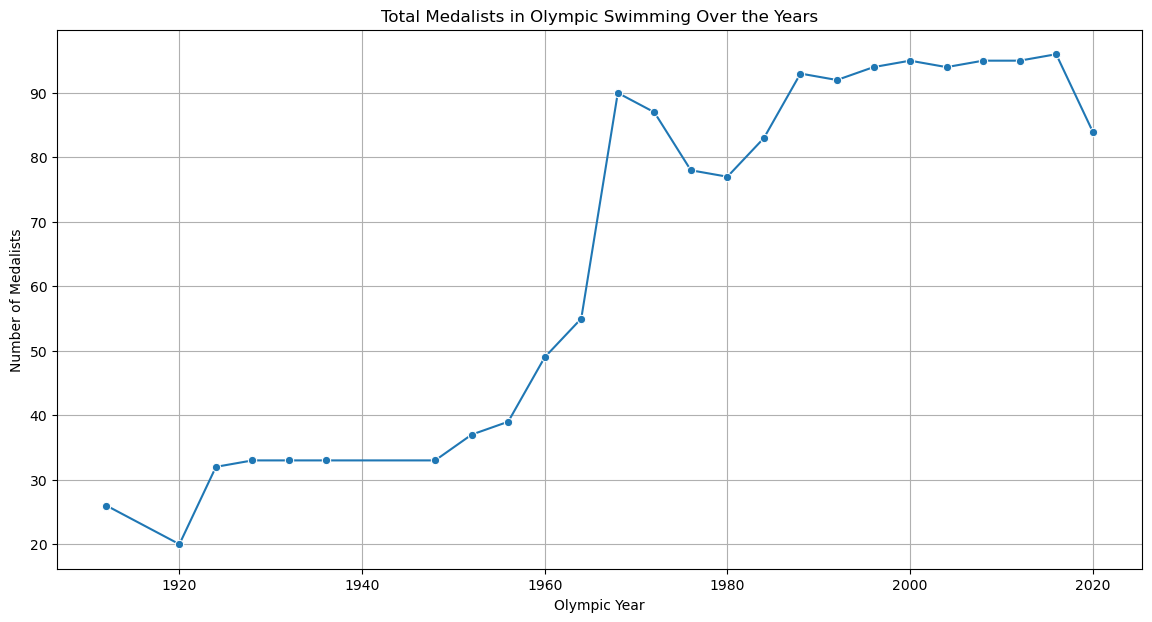

In [28]:
# Count total medalists per year (Ranks 1, 2, 3)
medalists_per_year = df[df['Rank'].isin([1, 2, 3])]['Year'].value_counts().sort_index()

plt.figure(figsize=(14, 7))
sns.lineplot(x=medalists_per_year.index, y=medalists_per_year.values, marker='o')
plt.title('Total Medalists in Olympic Swimming Over the Years')
plt.xlabel('Olympic Year')
plt.ylabel('Number of Medalists')
plt.grid(True)
plt.show()

This plot shows the total number of medalists (gold, silver, bronze) awarded in Olympic swimming events for each Olympic year. Fluctuations may reflect changes in the number of events, introduction of new disciplines, or changes in event formats.

## Improvement in Gold-Medal Times by Stroke
Compute and display the annual trend (seconds per Olympic cycle) for 100m events by stroke using OLS regression.

In [29]:
"""
Compute the annual trend (seconds per Olympic cycle) for 100 m events,
separately by stroke.  We use a simple OLS slope here; feel free to swap
for a Bayesian model later.
"""
import statsmodels.formula.api as smf

gold = df[df["Rank"] == 1]                  # keep gold medals only
gold_100 = gold[gold["distance_m"] == 100]  # focus on 100 m events

trends = []
for stroke, g in gold_100.groupby("Stroke", observed=True):
    model = smf.ols("result_seconds ~ Year", data=g).fit()
    slope = model.params["Year"]           # seconds per year
    trends.append({"stroke": stroke,
                   "sec_per_year": slope,
                   "sec_per_cycle": slope * 4})

trend_df = pd.DataFrame(trends)
print(trend_df.sort_values("sec_per_cycle"))

         stroke  sec_per_year  sec_per_cycle
0    Backstroke     -0.246559      -0.986237
2     Butterfly     -0.218527      -0.874109
3     Freestyle     -0.185011      -0.740044
1  Breaststroke     -0.182652      -0.730610


## Relay vs Individual Event Speeds
Analyze whether relay events yield better per-meter speeds than individual events, and test if the effect is gender-dependent.

In [30]:
import scipy.stats as st

# Add "speed" (sec per meter) for fair comparison across distances
df["speed_sec_per_m"] = df["result_seconds"] / df["distance_m"]

# Aggregate by gender × relay
grp = (df
       .dropna(subset=["speed_sec_per_m"])
       .groupby(["Gender", "is_relay"])
       .agg(mean_speed=("speed_sec_per_m", "mean"),
            std_speed=("speed_sec_per_m", "std"),
            n=("speed_sec_per_m", "size"))
       .reset_index())

print(grp)

# Quick hypothesis test (Welch t-test) per gender
for g in grp["Gender"].unique():
    relay  = df[(df["Gender"] == g) & (df["is_relay"])]
    solo   = df[(df["Gender"] == g) & (~df["is_relay"])]
    t, p   = st.ttest_ind(relay["speed_sec_per_m"].dropna(),
                          solo ["speed_sec_per_m"].dropna(),
                          equal_var=False)
    print(f"{g:>5}: relay vs solo  –  t = {t:6.2f},  p = {p:.3g}")

  Gender  is_relay  mean_speed  std_speed     n
0    Men     False    0.614259   0.094488  1811
1    Men      True   84.671157  35.861743   378
2  Women     False    0.669182   0.094851  1696
3  Women      True   71.328945  21.070194   327
  Men: relay vs solo  –  t =  45.57,  p = 2.03e-155
Women: relay vs solo  –  t =  60.64,  p = 1.32e-179


C:\Users\USER001\AppData\Local\Temp\ipykernel_1932\539065032.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Gender", "is_relay"])


## Country Improvement Trends Since 2000
Identify countries with the steepest improvement in gold-medal times since 2000 using linear regression.

In [31]:
from sklearn.linear_model import LinearRegression

recent = gold[gold["Year"] >= 2000]

slopes = []
for team, g in recent.groupby("Team", observed=True):
    if len(g) < 4:            # need enough data points
        continue
    X = g[["Year"]].values
    y = g["result_seconds"].values
    lin = LinearRegression().fit(X, y)
    slopes.append({"team": team, "sec_per_year": lin.coef_[0],
                   "medals": len(g)})

country_trend = (pd.DataFrame(slopes)
                 .sort_values("sec_per_year")   # most negative (fastest gains) first
                 .reset_index(drop=True))

print(country_trend.head(10))

  team  sec_per_year  medals
0  GBR    -25.288967       5
1  UKR    -15.176964       5
2  CHN    -11.832560      10
3  AUS    -11.537262      26
4  JPN     -6.194280       5
5  FRA     -5.306635       7
6  NED     -1.660733       9
7  HUN     -0.607337       6
8  USA      5.185933      74
9  ITA     42.349219       5


## Improvement Trends in 100m Freestyle by Gender
Analyze and visualize the rate of improvement in 100m freestyle gold-medal times for men and women separately.

--- Men ---
Annual slope (seconds/year): -0.161
Olympic cycle slope (seconds/4 years): -0.644

--- Women ---
Annual slope (seconds/year): -0.229
Olympic cycle slope (seconds/4 years): -0.916



C:\Users\USER001\AppData\Local\Temp\ipykernel_1932\3139269039.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for gender, g in freestyle_100_gold.groupby('Gender'):
C:\Users\USER001\AppData\Local\Temp\ipykernel_1932\3139269039.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for gender, g in freestyle_100_gold.groupby('Gender'):


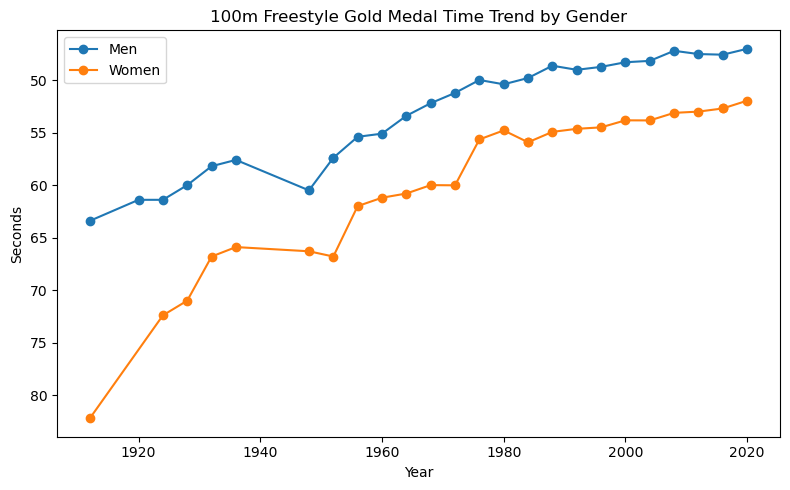

In [32]:
# Improvement trend in 100m freestyle gold medal times by gender
# Check if the rate of improvement in 100m freestyle gold medal times differs between men and women.
import statsmodels.formula.api as smf
# Filter for 100m freestyle, gold medal only
freestyle_100_gold = df[(df['distance_m'] == 100) & (df['Stroke'] == 'Freestyle') & (df['Rank'] == 1)]
# Separate regression for each gender
for gender, g in freestyle_100_gold.groupby('Gender'):
    model = smf.ols('result_seconds ~ Year', data=g).fit()
    print(f'--- {gender} ---')
    print(f'Annual slope (seconds/year): {model.params["Year"]:.3f}')
    print(f'Olympic cycle slope (seconds/4 years): {model.params["Year"]*4:.3f}')
    print()
# Visual comparison
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
for gender, g in freestyle_100_gold.groupby('Gender'):
    plt.plot(g['Year'], g['result_seconds'], marker='o', label=gender)
plt.gca().invert_yaxis()
plt.title('100m Freestyle Gold Medal Time Trend by Gender')
plt.xlabel('Year')
plt.ylabel('Seconds')
plt.legend()
plt.tight_layout()
plt.show()

## Data Loading and Initial Inspection
Load the dataset, check for file existence, and display basic information such as the first few rows, dataset info, and descriptive statistics.

In [33]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

file_path = os.path.join('..','data', 'Olympic_Swimming.csv')

# Check if the file exists
if not os.path.exists(file_path):
    print(f"Error: Data file not found at {file_path}")
else:
    df = pd.read_csv(file_path)
    print("Data loaded successfully!")

# Display basic information
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nDescriptive Statistics:")
print(df.describe())

Data loaded successfully!

First 5 rows:
  Location  Year Distance (in meters)      Stroke  Relay? Gender Team  \
0    Tokyo  2020                 100m  Backstroke       0    Men  ROC   
1    Tokyo  2020                 100m  Backstroke       0    Men  ROC   
2    Tokyo  2020                 100m  Backstroke       0    Men  USA   
3    Tokyo  2020                 100m  Backstroke       0    Men  ITA   
4    Tokyo  2020                 100m  Backstroke       0    Men  CHN   

              Athlete Results  Rank  
0        Evgeny Rylov   51.98     1  
1  Kliment Kolesnikov      52     2  
2         Ryan Murphy   52.19     3  
3       Thomas Ceccon    52.3     4  
4            Jiayu Xu   52.51     4  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4359 entries, 0 to 4358
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Location              4359 non-null   object
 1   Year           